# Store US Stock Prices in HDF5 Format

## Imports

In [1]:
import pandas as pd

from datetime import datetime

## Load source data

In [2]:
filename = './us_stocks.csv'
data = pd.read_csv(filename)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15389314 entries, 0 to 15389313
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ticker       object 
 1   date         object 
 2   open         float64
 3   high         float64
 4   low          float64
 5   close        float64
 6   volume       float64
 7   ex-dividend  float64
 8   split_ratio  float64
 9   adj_open     float64
 10  adj_high     float64
 11  adj_low      float64
 12  adj_close    float64
 13  adj_volume   float64
dtypes: float64(12), object(2)
memory usage: 1.6+ GB


## Apply required transformations

In [3]:
lower_lim = datetime(2000, 1, 1, 0, 0)

to_drop = [
    'open',
    'low',
    'high',
    'close',
    'volume',
]


def tweak_data(df):
    return (
        # Keep only the adjusted open, low, high, close, and
        # volume (OHLCV) prices, and rename by removing the
        # adj_ prefix
        df.drop(columns=[c for c in to_drop]
                ).rename(columns=lambda col: col.replace("adj_", ""))
        # Convert the date column to datetime format
        .assign(date=lambda df_: pd.to_datetime(df_.date), )
        # Select stock price data only from the year 2000 onwards
        .query('date >= @lower_lim')
        # Set ticker and date as index
        .set_index(['ticker', 'date'], append=True, drop=False)
    )


new_data = tweak_data(data)

new_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11343920 entries, (30, 'A', Timestamp('2000-01-03 00:00:00')) to (15389313, 'ZUMZ', Timestamp('2018-03-27 00:00:00'))
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ticker       object        
 1   date         datetime64[ns]
 2   ex-dividend  float64       
 3   split_ratio  float64       
 4   open         float64       
 5   high         float64       
 6   low          float64       
 7   close        float64       
 8   volume       float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 1.2+ GB


## Plot data

In [4]:
filtered_data = new_data.loc[new_data.ticker == 'NFLX']

filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3988 entries, (9706160, 'NFLX', Timestamp('2002-05-23 00:00:00')) to (9710147, 'NFLX', Timestamp('2018-03-27 00:00:00'))
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ticker       3988 non-null   object        
 1   date         3988 non-null   datetime64[ns]
 2   ex-dividend  3988 non-null   float64       
 3   split_ratio  3988 non-null   float64       
 4   open         3988 non-null   float64       
 5   high         3988 non-null   float64       
 6   low          3988 non-null   float64       
 7   close        3988 non-null   float64       
 8   volume       3988 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 345.2+ MB


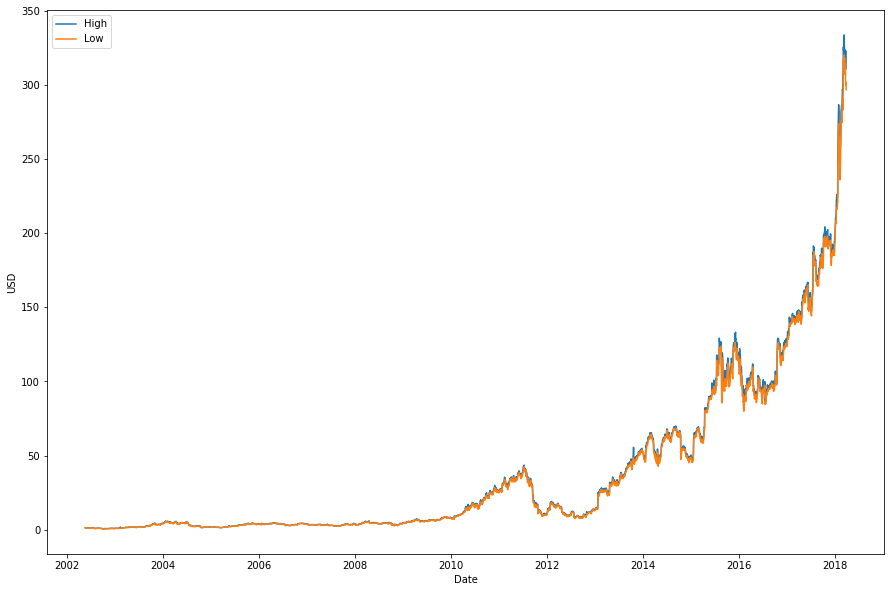

In [5]:
import matplotlib.pyplot as plt

x_dates = [d for d in filtered_data.date]

plt.figure(figsize=(15,10))
plt.plot(x_dates, filtered_data['high'], label='High')
plt.plot(x_dates, filtered_data['low'], label='Low')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()

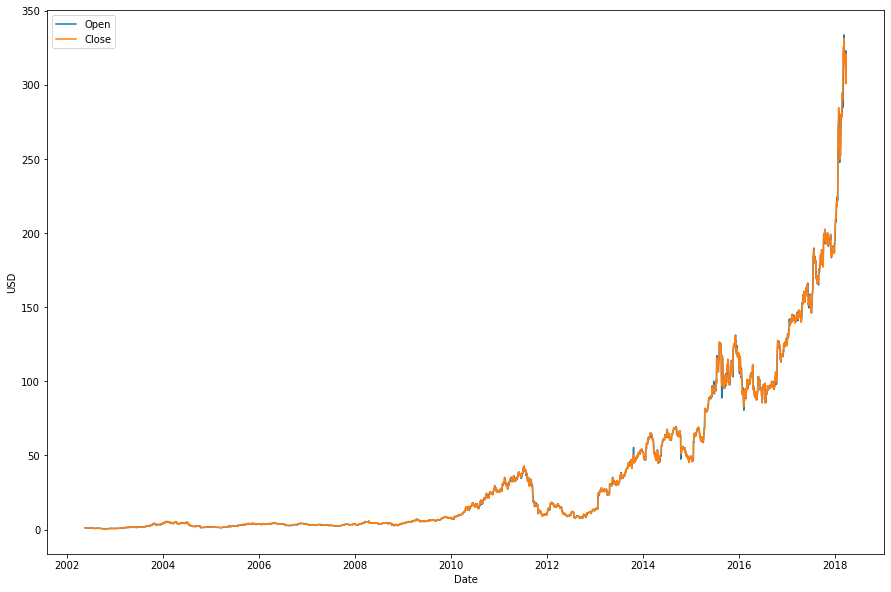

In [6]:
plt.figure(figsize=(15,10))
plt.plot(x_dates, filtered_data['open'], label='Open')
plt.plot(x_dates, filtered_data['close'], label='Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()

## Store in HDF5 format

In [7]:
# Store it in HDF5 format for fast access
new_data.to_hdf('data.h5', key='df', mode='w')